# Proyecto 2

In [130]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, roc_auc_score, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint
import xgboost as xgb

from tqdm import tqdm
from tqdm.notebook import tqdm
from alive_progress import alive_bar
import time
from progress.bar import Bar

## Exploracion

In [5]:
df = pd.read_csv("train_dataset.csv")
df.head()

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
0,35,170,85,97.0,0.9,0.9,1,1,118,78,...,70,142,19.8,1,1.0,61,115,125,1,1
1,20,175,110,110.0,0.7,0.9,1,1,119,79,...,71,114,15.9,1,1.1,19,25,30,1,0
2,45,155,65,86.0,0.9,0.9,1,1,110,80,...,57,112,13.7,3,0.6,1090,1400,276,0,0
3,45,165,80,94.0,0.8,0.7,1,1,158,88,...,46,91,16.9,1,0.9,32,36,36,0,0
4,20,165,60,81.0,1.5,0.1,1,1,109,64,...,47,92,14.9,1,1.2,26,28,15,0,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38984 entries, 0 to 38983
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  38984 non-null  int64  
 1   height(cm)           38984 non-null  int64  
 2   weight(kg)           38984 non-null  int64  
 3   waist(cm)            38984 non-null  float64
 4   eyesight(left)       38984 non-null  float64
 5   eyesight(right)      38984 non-null  float64
 6   hearing(left)        38984 non-null  int64  
 7   hearing(right)       38984 non-null  int64  
 8   systolic             38984 non-null  int64  
 9   relaxation           38984 non-null  int64  
 10  fasting blood sugar  38984 non-null  int64  
 11  Cholesterol          38984 non-null  int64  
 12  triglyceride         38984 non-null  int64  
 13  HDL                  38984 non-null  int64  
 14  LDL                  38984 non-null  int64  
 15  hemoglobin           38984 non-null 

In [4]:
df.smoking.value_counts()

0    24666
1    14318
Name: smoking, dtype: int64

## Preparacion

In [7]:
X = df.drop('smoking', axis=1)
y = df['smoking']

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

## Modelo

In [6]:
nn_model = Sequential()

nn_model.add(Dense(15, input_shape=(X_train.shape[1],), activation='relu'))
nn_model.add(Dense(10, activation='relu'))
nn_model.add(Dense(1, activation='sigmoid'))

nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(name='aucroc')])

history = nn_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=128,
    validation_data=(X_val, y_val)
)

Epoch 1/100
244/244 [==============================] - 2s 4ms/step - loss: 2.5121 - aucroc: 0.5885 - val_loss: 0.7227 - val_aucroc: 0.6773
Epoch 2/100
244/244 [==============================] - 1s 3ms/step - loss: 0.6687 - aucroc: 0.7041 - val_loss: 0.6588 - val_aucroc: 0.7135
Epoch 3/100
244/244 [==============================] - 1s 3ms/step - loss: 0.6214 - aucroc: 0.7307 - val_loss: 0.6104 - val_aucroc: 0.7375
Epoch 4/100
244/244 [==============================] - 1s 2ms/step - loss: 0.5975 - aucroc: 0.7430 - val_loss: 0.5974 - val_aucroc: 0.7484
Epoch 5/100
244/244 [==============================] - 1s 3ms/step - loss: 0.5875 - aucroc: 0.7470 - val_loss: 0.5882 - val_aucroc: 0.7520
Epoch 6/100
244/244 [==============================] - 1s 3ms/step - loss: 0.5867 - aucroc: 0.7454 - val_loss: 0.5789 - val_aucroc: 0.7551
Epoch 7/100
244/244 [==============================] - 1s 3ms/step - loss: 0.5832 - aucroc: 0.7455 - val_loss: 0.5785 - val_aucroc: 0.7589
Epoch 8/100
244/244 [======

In [7]:
y_probs = nn_model.predict(X_val)
y_pred = (y_probs > 0.48).astype(int)
print(classification_report(y_val, y_pred, zero_division=np.nan))

244/244 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.78      0.81      0.79      4975
           1       0.64      0.60      0.62      2822

    accuracy                           0.73      7797
   macro avg       0.71      0.70      0.71      7797
weighted avg       0.73      0.73      0.73      7797



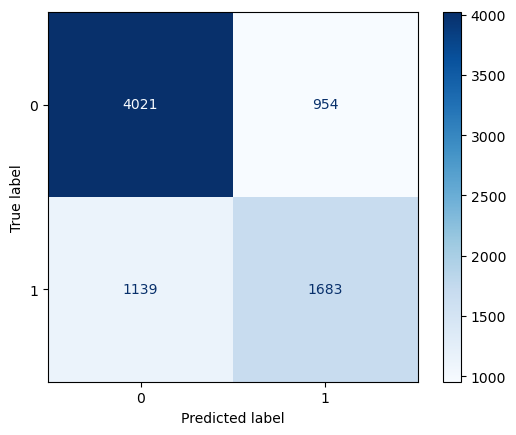

In [8]:
ConfusionMatrixDisplay.from_predictions(y_val, y_pred, cmap='Blues')
plt.show()

In [9]:
X_train['prob_1_nn'] = nn_model.predict(X_train)
X_val['prob_1_nn'] = y_probs

975/975 [==============================] - 2s 2ms/step


In [11]:
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [12]:
y_pred = xgb_model.predict(X_val)
print(classification_report(y_val, y_pred, zero_division=np.nan))

              precision    recall  f1-score   support

           0       0.83      0.81      0.82      4975
           1       0.68      0.71      0.69      2822

    accuracy                           0.77      7797
   macro avg       0.75      0.76      0.76      7797
weighted avg       0.78      0.77      0.77      7797



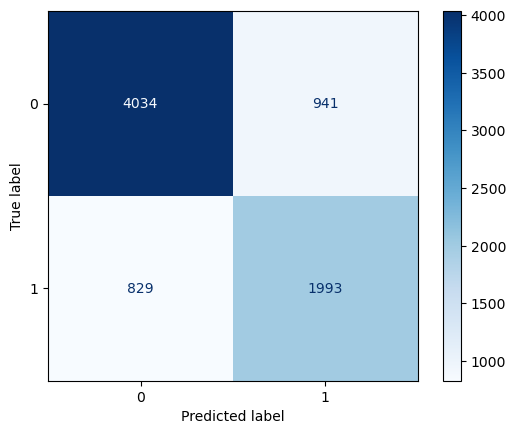

In [13]:
ConfusionMatrixDisplay.from_predictions(y_val, y_pred, cmap='Blues')
plt.show()

Neural Network
- learning rate: 10 ^ uniform(-3.3, -1)
- epochs: randint(7, 20)
- batch size: choice(32, 64, 128, 256)
- nodos capa 1: randint(7,22) 
- nodos capa 2: randint(3,17) 
- activacion capa 1: choice(relu, sigmoid, leaky_relu, tanh) 50% relu
- activacion capa 2: choice(relu, sigmoid, leaky_relu, tanh) 50% relu
- regularizacion capa 1: choice(0.1, 0.01, 0.001, 0.0001, 0)
- regularizacion capa 2: choice(0.1, 0.01, 0.001, 0.0001, 0)
- classes weights: choice(si, no)

XGBoost
- learning rate: uniform(0.01, 0.3)
- max bins: uniform(70, 200)
- min instances: uniform(20, 1000)
- max depth: randint(7, 20)
- num trees: (15, 150)
- scale pos weight: choice(1, 1.2, 1.5, 1.72)

## Random Search

In [114]:
import numpy as np
import pandas as pd
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.regularizers import l2
import random

class NNGBTClassifier:
    """
    Clase NNGBTClassifier para combinar modelos de red neuronal y XGBoost.

    Esta clase implementa un enfoque de stacking donde primero se entrena una red neuronal,
    y luego se utiliza su salida como una característica adicional en el entrenamiento
    de un modelo XGBoost.

    Atributos:
        learning_rate_nn (float): Tasa de aprendizaje para la red neuronal.
        epochs (int): Número de épocas para el entrenamiento de la red neuronal.
        batch_size (int): Tamaño del lote para el entrenamiento de la red neuronal.
        nodos_capa_1 (int): Número de nodos en la primera capa de la red neuronal.
        nodos_capa_2 (int): Número de nodos en la segunda capa de la red neuronal.
        activacion_capa_1 (str): Función de activación para la primera capa de la red neuronal.
        activacion_capa_2 (str): Función de activación para la segunda capa de la red neuronal.
        regularizacion_capa_1 (float): Término de regularización para la primera capa de la red neuronal.
        regularizacion_capa_2 (float): Término de regularización para la segunda capa de la red neuronal.
        classes_weights (str): Indica si se deben usar pesos de clases en la red neuronal.
        learning_rate_xgb (float): Tasa de aprendizaje para XGBoost.
        max_bins (int): Número máximo de bins para XGBoost.
        min_instances (int): Número mínimo de instancias para XGBoost.
        max_depth (int): Profundidad máxima para los árboles en XGBoost.
        num_trees (int): Número de árboles para XGBoost.
        scale_pos_weight (float): Peso de escala para las clases positivas en XGBoost.

    Métodos:
        fit: Entrena tanto la red neuronal como el modelo XGBoost con los datos proporcionados.
        predict: Realiza predicciones utilizando ambos modelos entrenados.
        set_params: Actualiza los parámetros de los modelos.
    """
    def __init__(
            self, 
            learning_rate_nn=0.01,
            epochs=10,
            batch_size=128,
            nodos_capa_1=15,
            nodos_capa_2=10,
            activacion_capa_1='relu',
            activacion_capa_2='relu',
            regularizacion_capa_1=0.01,
            regularizacion_capa_2=0.01,
            learning_rate_xgb=0.1,
            max_bins=100,
            min_instances=50,
            max_depth=10,
            num_trees=100,
            scale_pos_weight=1.5
        ):
        
        # Atributos para los parámetros de la red neuronal
        self.learning_rate_nn = learning_rate_nn
        self.epochs = epochs
        self.batch_size = batch_size
        self.nodos_capa_1 = nodos_capa_1
        self.nodos_capa_2 = nodos_capa_2
        self.activacion_capa_1 = activacion_capa_1
        self.activacion_capa_2 = activacion_capa_2
        self.regularizacion_capa_1 = regularizacion_capa_1
        self.regularizacion_capa_2 = regularizacion_capa_2

        # Atributos para los parámetros de XGBoost
        self.learning_rate_xgb = learning_rate_xgb
        self.max_bins = max_bins
        self.min_instances = min_instances
        self.max_depth = max_depth
        self.num_trees = num_trees
        self.scale_pos_weight = scale_pos_weight

        # Inicializar modelos
        self.nn_model = None
        self.xgb_model = None

    def create_nn_model(self, input_shape):
        model = Sequential()
        model.add(Dense(self.nodos_capa_1, input_shape=(input_shape,), activation=self.activacion_capa_1, kernel_regularizer=l2(self.regularizacion_capa_1)))
        model.add(Dense(self.nodos_capa_2, activation=self.activacion_capa_2, kernel_regularizer=l2(self.regularizacion_capa_2)))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate_nn), loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(name='aucroc')])
        return model

    def fit(self, X_train, y_train, validation_data):
        """
        Entrena la red neuronal y el modelo XGBoost.

        Parámetros:
            X_train (DataFrame): Datos de entrenamiento.
            y_train (Series): Etiquetas de entrenamiento.
            X_val (DataFrame): Datos de validación.
            y_val (Series): Etiquetas de validación.
        """
        self.nn_model = self.create_nn_model(X_train.shape[1])
        self.nn_model.fit(X_train, y_train, epochs=self.epochs, batch_size=self.batch_size, validation_data=validation_data, verbose=0)
        
        # Generar predicciones de la NN para usar como característica en XGBoost
        X_train_xgb = X_train.copy()
        X_train_xgb['prob_1_nn'] = self.nn_model.predict(X_train, verbose=0)
        
        # Configurar y entrenar el modelo XGBoost
        self.xgb_model = xgb.XGBClassifier(learning_rate=self.learning_rate_xgb, max_bin=self.max_bins, min_child_weight=self.min_instances, max_depth=self.max_depth, n_estimators=self.num_trees, scale_pos_weight=self.scale_pos_weight)
        self.xgb_model.fit(X_train_xgb, y_train)

    def predict(self, X):
        """
        Realiza predicciones utilizando el modelo de red neuronal y el modelo XGBoost en un enfoque de stacking.

        Parámetros:
            X (DataFrame): Datos para realizar predicciones.

        Retorna:
            array: Predicciones del modelo.
        """
        # Realizar predicciones con el modelo de red neuronal
        nn_predictions = self.nn_model.predict(X, verbose=0)

        # Añadir las predicciones de la red neuronal como una nueva característica para XGBoost
        X_xgb = X.copy()
        X_xgb['prob_1_nn'] = nn_predictions

        # Realizar predicciones con el modelo XGBoost
        return self.xgb_model.predict(X_xgb)

    def set_params(self, **kwargs):
        """
        Actualiza los parámetros de los modelos con los valores proporcionados.

        Parámetros:
            **kwargs: Diccionario de parámetros y sus nuevos valores.
        """
        for key, value in kwargs.items():
            if hasattr(self, key):
                setattr(self, key, value)
            else:
                raise ValueError(f"Parametro '{key}' no es válido para esta clase.")

In [170]:
class RandomSearch:
    def __init__(self, model, param_dist, score='roc_auc', generations=10, population_size=20):
        self.model = model
        self.param_dist = param_dist
        self.generations = generations
        self.population_size = population_size
        self.score = score
        self.history = {
            'roc_auc': [],
            'f1_score_1': []
        }
        self.best_model = None
        self.best_score = 0
        self.best_params = None
        self.generation = 0
    
    def fit(self, x, y, validation_data):
        for generation in range(self.generations + 1):
            population = self.random_population()
            
            roc_auc_scores = []
            f1_scores = []
            
            progress_bar = tqdm(total=self.population_size, desc="Generation " + str(self.generation))
            
            for params in population:
                self.model.set_params(**params)
                self.model.fit(x, y, validation_data)
                y_pred = self.model.predict(validation_data[0])
                roc_auc_scores.append(roc_auc_score(validation_data[1], y_pred))
                f1_scores.append(f1_score(validation_data[1], y_pred))
                
                if self.score == 'roc_auc':
                    if roc_auc_scores[-1] > self.best_score:
                        self.best_score = roc_auc_scores[-1]
                        self.best_model = self.model
                        self.best_params = params
                else:
                    if f1_scores[-1] > self.best_score:
                        self.best_score = f1_scores[-1]
                        self.best_model = self.model
                        self.best_params = params
                
                progress_bar.update(1)
                
            self.generation += 1
            
            self.history['roc_auc'].append(roc_auc_scores)
            self.history['f1_score_1'].append(f1_scores)
            
    def generate_params(self):
        return {param: random.choice(values) for param, values in self.param_dist.items()}
    
    def random_population(self):
        return [self.generate_params() for i in range(self.population_size)]

In [133]:
class GeneticSearch:
    def __init__(self, model, param_dist, param_methods, fitness='roc_auc', generations=10, population_size=20, num_to_select='auto', num_to_keep='auto'):
        if population_size <= num_to_select:
            raise ValueError("num_to_select should be less to population_size")
        
        if population_size <= num_to_keep:
            raise ValueError("num_to_keep should be less to population_size")
        
        self.model = model
        self.param_dist = param_dist
        self.generations = generations
        self.population_size = population_size
        self.param_methods = self.transform_param_methods(param_methods)
        self.generation = 0
        self.fitness = 'roc_auc'
        
        if num_to_select == 'auto':
            self.num_to_select = int(round(0.25 * population_size))
        else:
            self.num_to_select = num_to_select
            
        if num_to_keep == 'auto':
            self.num_to_keep = int(round(0.25 * population_size))
        else:
            self.num_to_keep = num_to_keep
        
        self.history = {
            'roc_auc': [],
            'f1_score_1': []
        }

        self.best_model = None
        self.best_score = 0
        self.best_params = None
        
        self.population = self.generate_random_population()
        
    def transform_param_methods(self, param_methods):
        transformed_methods = {}

        for param, (reproduction_method, mutation_method) in param_methods.items():
            reproduction_func_name, *reproduction_params = reproduction_method
            mutation_func_name, *mutation_params = mutation_method if mutation_method else (None, None)

            reproduction_func = getattr(self, f"{reproduction_func_name}_reproduction")(*reproduction_params)
            mutation_func = getattr(self, f"{mutation_func_name}_mutation")(*mutation_params) if mutation_func_name else self.maintain

            transformed_methods[param] = (reproduction_func, mutation_func)
        
        return transformed_methods
    
    def individual_fit(self, x, y, validation_data, params):
        # Establecer los parámetros en el modelo
        self.model.set_params(**params)

        # Ajustar el modelo y obtener predicciones
        self.model.fit(x, y, validation_data)
        y_pred = self.model.predict(validation_data[0])

        # Calcular puntajes
        roc_auc = roc_auc_score(validation_data[1], y_pred)
        f1 = f1_score(validation_data[1], y_pred)
        
        return roc_auc, f1
    
    def fit_population(self, x, y, validation_data):
        # Inicializar listas para puntajes
        roc_auc_scores = []
        f1_scores = []
        
        progress_bar = tqdm(total=self.population_size, desc="Generation " + str(self.generation))
        
        for params in self.population:
            roc_auc, f1 = self.individual_fit(x, y, validation_data, params)

            # Registrar puntajes en las listas
            roc_auc_scores.append(roc_auc)
            f1_scores.append(f1)

            # Actualizar el mejor modelo si es necesario
            if self.fitness == 'roc_auc' and roc_auc > self.best_score:
                self.best_score = roc_auc
                self.best_model = self.model
                self.best_params = params
            elif f1 > self.best_score:
                self.best_score = f1
                self.best_model = self.model
                self.best_params = params

            progress_bar.update(1)
            
        if self.fitness == 'roc_auc':
            population_with_scores = [(individual, roc_auc_score) for individual, roc_auc_score in zip(self.population, roc_auc_scores)]
        else:
            population_with_scores = [(individual, roc_auc_score) for individual, roc_auc_score in zip(self.population, f1_scores)] # Guardar los resultados en la historia
        
        self.history['roc_auc'].append(roc_auc_scores)
        self.history['f1_score_1'].append(f1_scores)

        sorted_population = sorted(population_with_scores, key=lambda x: x[1], reverse=True)
        
        progress_bar.close()
        
        return sorted_population
        
    
    def fit(self, x, y, validation_data):
        
        for generation in range(self.generations):
            sorted_population = self.fit_population(x, y, validation_data)
            
            selected_individuals = self.select(sorted_population)

            offspring = self.reproduce(selected_individuals)
            
            individual_to_keep = self.keep(sorted_population)
            
            self.population = individual_to_keep + offspring
            
            self.generation += 1
        
        self.fit_population(x, y, validation_data)

    
    def shuffle_reproduction(self, weight=0.5):
        def f(param1, param2):
            return np.random.choice([param1, param2], p=[weight, 1 - weight])
        return f
    
    def mean_reproduction(self, weight=0.5, disc=False):
        def f(param1, param2):
            new_param = (weight * param1) + ((1 - weight) * param2)
            return new_param
        
        def f_disc(param1, param2):
            new_param = (weight * param1) + ((1 - weight) * param2)
            return int(round(new_param))
        
        if disc:
            return f_disc
        
        return f
    
    def proportional_mutation(self, mutation_rate=0.05, disc=True):
        def f(param, name):
            sign = np.random.choice([1, -1])
            new_param = param * (1 + (sign * mutation_rate))
            return new_param
        
        def f_disc(param, name):
            sign = np.random.choice([1, -1])
            new_param = param * (1 + (sign * mutation_rate))
            return int(round(new_param))
        
        if disc:
            return f_disc
        
        return f
    
    def mean_mutation(self, mutation_rate=0.2, disc=True):
        def f(param, name):
            random_param = random.choice(param_dist[name])
            new_param = ((1 - mutation_rate) * param) + (mutation_rate * random_param)
            return new_param
    
        def f_disc(param, name):
            random_param = random.choice(param_dist[name])
            new_param = ((1 - mutation_rate) * param) + (mutation_rate * random_param)
            return int(round(new_param))
    
        if disc:
            return f_disc
        
        return f
    
    def maintain(self, param, name=None):
        return param
    
    def generate_random_params(self):
        return {param: random.choice(values) for param, values in self.param_dist.items()}
        
    def generate_random_population(self):
        return [self.generate_random_params() for i in range(self.population_size)]
    
    def select(self, sorted_population):
        return [individual for individual, score in sorted_population[:self.num_to_select]]
    
    def keep(self, sorted_population):
        return [individual for individual, score in sorted_population[:self.num_to_keep]]
    
    def reproduce(self, selected_individuals):
        num_offspring = self.population_size - self.num_to_keep
        offspring = []

        while len(offspring) < num_offspring:
            parents = random.sample(selected_individuals, k=2)
            child_params = {}
            for param, value in parents[0].items():
                child_params[param] = self.param_methods[param][0](value, parents[1][param])
                
            mutated_child = self.mutate(child_params)
            offspring.append(mutated_child)

        return offspring
    
    def mutate(self, offspring):
        mutated_child = offspring.copy()
        for param, value in mutated_child.items():
            mutated_child[param] = self.param_methods[param][1](value, param)

        return mutated_child

In [168]:
nngbt = NNGBTClassifier()

param_dist = {
    'learning_rate_nn': 10 ** np.random.uniform(-4, 0, 1000),
    'epochs': np.random.randint(5, 30, 1000),
    'batch_size': [32, 64, 128, 256, 518],
    'nodos_capa_1': np.random.randint(3, 50, 1000),
    'nodos_capa_2': np.random.randint(3, 50, 1000),
    'activacion_capa_1': ['relu', 'sigmoid', 'leaky_relu', 'tanh'],
    'activacion_capa_2': ['relu', 'sigmoid', 'leaky_relu', 'tanh'],
    'regularizacion_capa_1': [1, 0.1, 0.01, 0.001, 0.0001, 0],
    'regularizacion_capa_2': [1, 0.1, 0.01, 0.001, 0.0001, 0],
    'learning_rate_xgb': np.random.uniform(0.001, 1, 1000),
    'max_bins': np.random.randint(10, 1000, 1000),
    'min_instances': np.random.randint(1, 2000, 1000),
    'max_depth': np.random.randint(4, 20, 1000),
    'num_trees': np.random.randint(15, 50, 1000),
    'scale_pos_weight': np.random.uniform(0, 3, 1000)
}

param_methods = {
    'learning_rate_nn': (('mean', 0.5, False), ('proportional', 0.3, False)),
    'epochs': (('shuffle', 0.55), ('mean', 0.3, True)),
    'batch_size': (('shuffle', 0.5), ('mean', 0.3, True)),
    'nodos_capa_1': (('shuffle', 0.5), ('mean', 0.3, True)),
    'nodos_capa_2': (('shuffle', 0.5), ('mean', 0.3, True)),
    'activacion_capa_1': (('shuffle', 0.5), None),
    'activacion_capa_2': (('shuffle', 0.5), None),
    'regularizacion_capa_1': (('mean', 0.5, False), ('proportional', 0.3, False)),
    'regularizacion_capa_2': (('mean', 0.5, False), ('proportional', 0.3, False)),
    'learning_rate_xgb': (('mean', 0.5, False), ('proportional', 0.3, False)),
    'max_bins': (('shuffle', 0.5), ('proportional', 0.3, True)),
    'min_instances': (('mean', 0.6, True), ('mean', 0.3, True)),
    'max_depth': (('shuffle', 0.5), None),
    'num_trees': (('mean', 0.5, True), ('mean', 0.3, True)),
    'scale_pos_weight': (('shuffle', 0.5), ('mean', 0.3, False))
}

In [172]:
gs = GeneticSearch(nngbt, param_dist, param_methods, generations=10, population_size=25, num_to_select=13, num_to_keep=3)
gs.fit(X_train, y_train, (X_val, y_val))

Generation 0:   0%|          | 0/3 [00:00<?, ?it/s]

Generation 1:   0%|          | 0/3 [00:00<?, ?it/s]

Generation 2:   0%|          | 0/3 [00:00<?, ?it/s]

Generation 3:   0%|          | 0/3 [00:00<?, ?it/s]

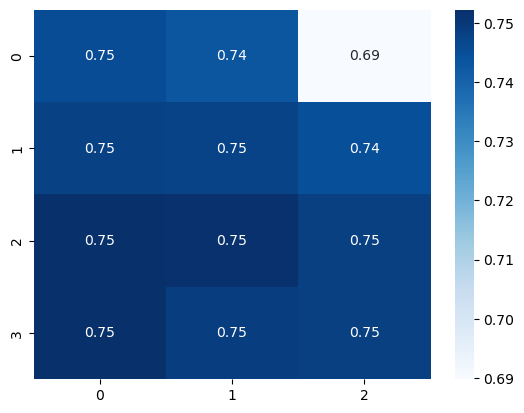

In [173]:
random_scores = np.array(gs.history['roc_auc'], dtype='float')

indices = np.argsort(random_scores, axis=1)[:, ::-1]

sorted_arr = np.take_along_axis(random_scores, indices, axis=1)
sns.heatmap(sorted_arr, cmap='Blues', annot=True)
plt.show()

In [169]:
nngbt = NNGBTClassifier()

rs = RandomSearch(nngbt, param_dist, generations=10, population_size=25)

rs.fit(X_train, y_train, (X_val, y_val))

Generation 0:   0%|          | 0/3 [00:00<?, ?it/s]

Generation 1:   0%|          | 0/3 [00:00<?, ?it/s]

Generation 2:   0%|          | 0/3 [00:00<?, ?it/s]

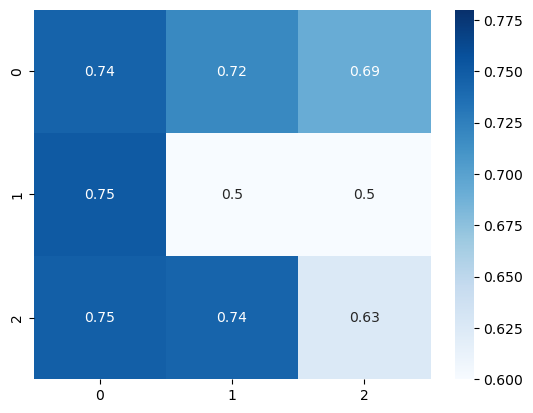

In [171]:
random_scores = np.array(rs.history['roc_auc'], dtype='float')

indices = np.argsort(random_scores, axis=1)[:, ::-1]

sorted_arr = np.take_along_axis(random_scores, indices, axis=1)
sns.heatmap(sorted_arr, cmap='Blues', vmin=0.6, vmax=0.78, annot=True)
plt.show()